# Machine learning - sprint 1
authors: Allart Ewoud, Van Hees Maxime, Breda Bram

## Importing data

In [1]:
# Import pandas and read csv using pandas
import pandas as pd
import seaborn as sn
import numpy as np

original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

# display the data and see how it formulated
pd.set_option("display.max_columns", None)
original_df.head()

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
0,#1,Kin Khao - Thai Eatery,5.0 of 5 bubbles,922 reviews,$$ - $$$|Thai|Healthy|Vegetarian Friendly,"Donkersteeg 21-23, Ghent 9000 Belgium",+32 468 10 59 59,http://www.kinkhao.be/,http://www.kinkhao.be/site/menu/,True,gent@kinkhao.be,True,False,5.0,5.0,4.5,-1.0,"Differing from formal dining establishments, K...",NaN,€10 - €28,"Thai, Healthy","Vegetarian Friendly, Vegan Options, Gluten Fre...","Dinner, Drinks","Reservations, Seating, Serves Alcohol, Free Wi...",13969825
1,#1,'t Sleutelgat,5.0 of 5 bubbles,200 reviews,$$$$|French|Belgian|European,"Kasseide 78, Ninove 9400 Belgium",+32 54 56 63 09,http://www.restaurant-sleutelgat.be/,NaN,True,restaurant_sleutelgat@telenet.be,False,True,5.0,5.0,4.5,5.0,NaN,NaN,€32 - €74,"French, Belgian, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Free Wifi, Reservations, Outdoor Seating, Seat...",740727
2,#2,Royal India Restaurant,4.5 of 5 bubbles,774 reviews,$$ - $$$|Indian|Asian|Vegetarian Friendly,"Donkersteeg 19 Near hotel novotel gent, Ghent ...",+32 497 40 78 27,NaN,NaN,True,royalindiabelgium@gmail.com,True,False,4.5,4.5,4.5,-1.0,"For fresh ingredients and bold flavour, dine i...",NaN,€15 - €30,"Indian, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Late Night, Drinks","Takeout, Reservations, Seating, Highchairs Ava...",12188645
3,#3,Roots,5.0 of 5 bubbles,282 reviews,$$ - $$$|Belgian|European|Healthy,"Vrouwebroersstraat 5, Ghent 9000 Belgium",+32 9 310 67 73,http://www.rootsgent.be/,NaN,True,Info@rootsgent.be,True,True,5.0,4.5,5.0,-1.0,NaN,NaN,€40 - €80,"Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",9710340
4,#1,Mirage,4.5 of 5 bubbles,240 reviews,$$ - $$$|French|Belgian|Dutch,"Brusselsestraat 99, Dendermonde 9200 Belgium",+32 52 55 48 26,http://mirage-ma.be/,http://mirage-ma.be/feestdagenmenus/,True,contact@mirage-ma.be,True,False,4.5,4.5,4.5,-1.0,NaN,NaN,€16 - €64,"French, Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Accepts Visa, Reservations, Outdoor Seating, S...",8298124


## Split in test & train data

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(original_df, random_state=0, train_size = 0.8)
df = df_train

## Data clean-up

First we start with cleaning of the less complicated data. This includes the collumns general rating, number of reviews and rank.

### General rating, number of reviews & rank

In [6]:
# general rating
df["general rating"] = df["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
df["general rating"] = pd.to_numeric(df["general rating"])

# number of reviews
df["number of reviews"] = df["number of reviews"].apply(lambda x: int(str(x).split(' ')[0]))
df["number of reviews"] = pd.to_numeric(df["number of reviews"])

# rank
df["rank"] = df_train["rank"].str.split("#").str[1]
df["rank"] = pd.to_numeric(df["rank"])

df.head()

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
175,NaN,Baravins,5.0,52,$$ - $$$|Belgian|Wine Bar,"Steendam 53, Ghent 9000 Belgium",+32 9 324 00 85,http://www.baravins.be/,http://www.baravins.be/menukaart,True,info@baravins.be,False,False,4.5,5.0,5.0,-1.0,NaN,NaN,€6 - €25,"Wine Bar, Belgian",NaN,"Dinner, Late Night, Drinks","Takeout, Reservations, Outdoor Seating, Seatin...",7196121
1901,NaN,Bystro Jamien,5.0,1,European,"Rijvisschestraat 124, Zwijnaarde 9052 Belgium",+32 9 396 60 70,http://www.bystrojamien.be/,NaN,False,NaN,False,False,-1.0,-1.0,-1.0,-1.0,NaN,NaN,No pricing available,European,NaN,NaN,NaN,21349450
461,NaN,De Brabander,4.0,50,$$ - $$$|Belgian|European|Vegetarian Friendly,"Sint-Jozefstraat 2c, Tielrode 9140 Belgium",+32 3 296 66 22,http://eetcafe-debrabander.be/,https://eetcafe-debrabander.be/menu/,False,NaN,False,False,4.5,4.5,4.5,-1.0,NaN,NaN,No pricing available,"Belgian, European",Vegetarian Friendly,Dinner,"Reservations, Seating, Table Service, Outdoor ...",8649229
1493,NaN,Zelzate Dolce Vita,4.0,8,$$ - $$$|Italian,"Franz Wittoucklaan 25, Zelzate 9060 Belgium",NaN,NaN,NaN,False,NaN,False,False,-1.0,-1.0,-1.0,-1.0,NaN,NaN,No pricing available,Italian,NaN,NaN,Reservations,12613311
2385,NaN,Praatcafé 't Dolfijntje,-1.0,0,NaN,"Paepestraat 165, Wichelen 9260 Belgium",+32 495 14 14 07,https://www.t-dolfijntje.be/,NaN,True,info@t-dolfijntje.be,False,False,-1.0,-1.0,-1.0,-1.0,NaN,We zijn momenteel bezig met grote renovatie- e...,No pricing available,NaN,NaN,"Breakfast, Lunch, Dinner",NaN,23501261


### Price range
A collumn that is a bit more complicated is price range, this collumn will be split in 2, after this the average is taken.

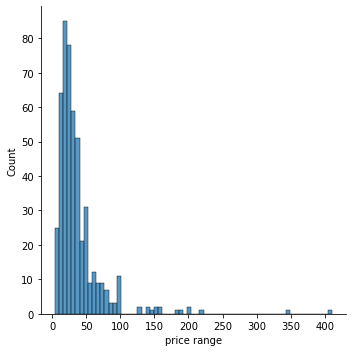

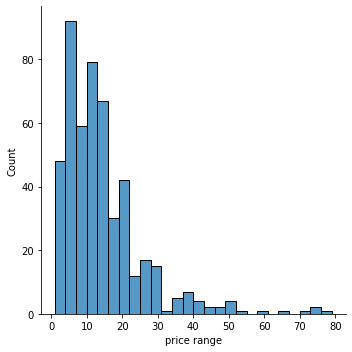

In [7]:
upper_bound = df_train["price range"].str.split(" - ").str[1]
upper_bound = upper_bound.str.split('€').str[1]
upper_bound = pd.to_numeric(upper_bound)

lower_bound = df_train["price range"].str.split(" - ").str[0]
lower_bound = lower_bound.str.split('€').str[1]
lower_bound = pd.to_numeric(lower_bound)

sn.displot(upper_bound)
sn.displot(lower_bound)

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
175,NaN,Baravins,5.0,52,$$ - $$$|Belgian|Wine Bar,"Steendam 53, Ghent 9000 Belgium",+32 9 324 00 85,http://www.baravins.be/,http://www.baravins.be/menukaart,True,info@baravins.be,False,False,4.5,5.0,5.0,-1.0,NaN,NaN,0.0,"Wine Bar, Belgian",NaN,"Dinner, Late Night, Drinks","Takeout, Reservations, Outdoor Seating, Seatin...",7196121
1901,NaN,Bystro Jamien,5.0,1,European,"Rijvisschestraat 124, Zwijnaarde 9052 Belgium",+32 9 396 60 70,http://www.bystrojamien.be/,NaN,False,NaN,False,False,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,European,NaN,NaN,NaN,21349450
461,NaN,De Brabander,4.0,50,$$ - $$$|Belgian|European|Vegetarian Friendly,"Sint-Jozefstraat 2c, Tielrode 9140 Belgium",+32 3 296 66 22,http://eetcafe-debrabander.be/,https://eetcafe-debrabander.be/menu/,False,NaN,False,False,4.5,4.5,4.5,-1.0,NaN,NaN,NaN,"Belgian, European",Vegetarian Friendly,Dinner,"Reservations, Seating, Table Service, Outdoor ...",8649229
1493,NaN,Zelzate Dolce Vita,4.0,8,$$ - $$$|Italian,"Franz Wittoucklaan 25, Zelzate 9060 Belgium",NaN,NaN,NaN,False,NaN,False,False,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,Italian,NaN,NaN,Reservations,12613311
2385,NaN,Praatcafé 't Dolfijntje,-1.0,0,NaN,"Paepestraat 165, Wichelen 9260 Belgium",+32 495 14 14 07,https://www.t-dolfijntje.be/,NaN,True,info@t-dolfijntje.be,False,False,-1.0,-1.0,-1.0,-1.0,NaN,We zijn momenteel bezig met grote renovatie- e...,NaN,NaN,NaN,"Breakfast, Lunch, Dinner",NaN,23501261


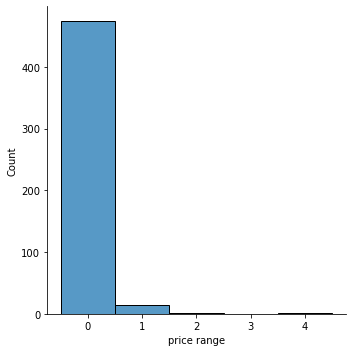

In [13]:
from sklearn import preprocessing

average = (upper_bound-lower_bound)/2

transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': 5, 'labels': [0, 1, 2, 3, 4], 'retbins': True})
avg_quantfied = transformer.fit_transform(average)

#visualize the data
sn.displot(avg_quantfied[0])

df['price range'] =  pd.to_numeric(avg_quantfied[0])
df.head()

### Food, service & value rating
As we can see in the next scatter matrix (diagonal), food, service & value rating have a lot of -1 values. 


array([[<AxesSubplot:xlabel='food rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='food rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='service rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='value rating'>]],
      dtype=object)

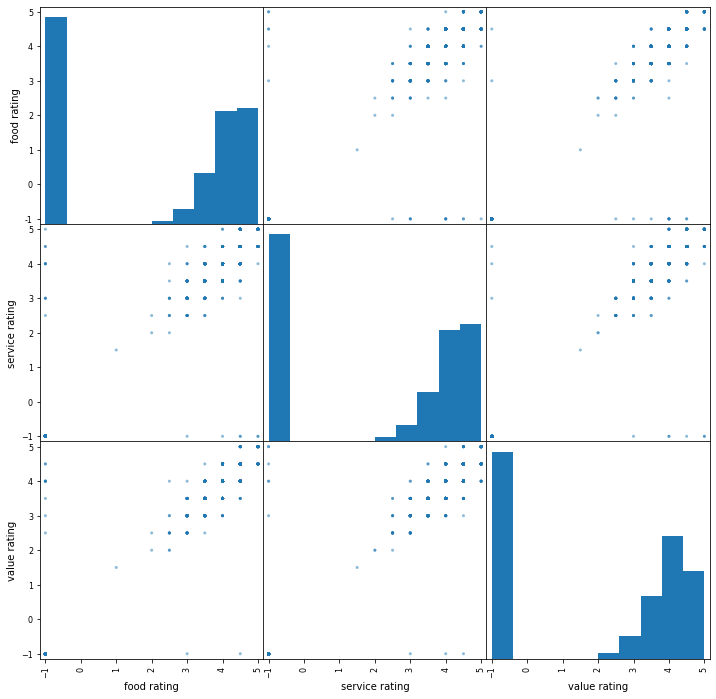

In [17]:
pd.plotting.scatter_matrix(df[["food rating","service rating","value rating"]], figsize = (12,12))

This is something that needs to be solved, -1 is not a valid rating. There are a few option that can solve this issue: 
- Drop the rows with a -1 value
- Drop the column 
- Change the value to a meaningfull value like zero, mean, medain, etc.

Dropping the rows would result in alot of data being lost. 